In [1]:
from google.colab import drive
import pandas as pd
# Montar Google Drive
drive.mount('/content/drive')

# Leer el archivo CSV
df = pd.read_csv('/content/drive/My Drive/Beca bootcamp/insurance.csv')

# Inspección inicial
print(df.head())
print(df.describe())
print(df.info())
print(df.isnull().sum())

Mounted at /content/drive
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entr

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una columna binaria 'high_cost' para la clasificación
median_charges = df['charges'].median()
df['high_cost'] = (df['charges'] > median_charges).astype(int)

# Definir X (características) y y (target)
X = df.drop(columns=['charges', 'high_cost'])
y = df['high_cost']

# Definir las columnas numéricas y categóricas
numerical_cols = ['age', 'bmi', 'children']
categorical_cols = ['sex', 'smoker', 'region']

# Crear el preprocesamiento para cada tipo de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Escalado de las características numéricas
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # OneHotEncoding para las variables categóricas
    ])

# Pipeline para la regresión logística
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Pipeline para KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Pipeline para Árbol de Decisión
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar los modelos
log_reg_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)
tree_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [7]:
# Evaluación de los modelos
y_pred_log_reg = log_reg_pipeline.predict(X_test)
y_pred_knn = knn_pipeline.predict(X_test)
y_pred_tree = tree_pipeline.predict(X_test)

# Evaluación con classification_report y matriz de confusión
print("Regresión Logística - Evaluación:")
print(classification_report(y_test, y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))

print("KNN - Evaluación:")
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))

print("Árbol de Decisión - Evaluación:")
print(classification_report(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))


Regresión Logística - Evaluación:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       207
           1       0.89      0.90      0.90       195

    accuracy                           0.90       402
   macro avg       0.90      0.90      0.90       402
weighted avg       0.90      0.90      0.90       402

[[186  21]
 [ 19 176]]
KNN - Evaluación:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       207
           1       0.88      0.86      0.87       195

    accuracy                           0.88       402
   macro avg       0.88      0.88      0.88       402
weighted avg       0.88      0.88      0.88       402

[[185  22]
 [ 28 167]]
Árbol de Decisión - Evaluación:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       207
           1       0.85      0.89      0.87       195

    accuracy                           0.87       40

In [8]:
#GridSearchCV para KNN
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Mejor modelo
print("Mejores parámetros KNN:", grid_search_knn.best_params_)


Mejores parámetros KNN: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}


In [9]:
#RandomizedSearchCV para el Árbol de Decisión
from scipy.stats import randint

param_dist_tree = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20)
}

random_search_tree = RandomizedSearchCV(tree_pipeline, param_dist_tree, n_iter=100, cv=5, random_state=42)
random_search_tree.fit(X_train, y_train)

# Mejor modelo
print("Mejores parámetros Árbol de Decisión:", random_search_tree.best_params_)


Mejores parámetros Árbol de Decisión: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 18}


KNN Optimizado - Evaluación:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       207
           1       0.92      0.87      0.90       195

    accuracy                           0.90       402
   macro avg       0.90      0.90      0.90       402
weighted avg       0.90      0.90      0.90       402

[[193  14]
 [ 25 170]]
Árbol de Decisión Optimizado - Evaluación:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       207
           1       0.98      0.85      0.91       195

    accuracy                           0.92       402
   macro avg       0.93      0.92      0.92       402
weighted avg       0.93      0.92      0.92       402

[[204   3]
 [ 30 165]]


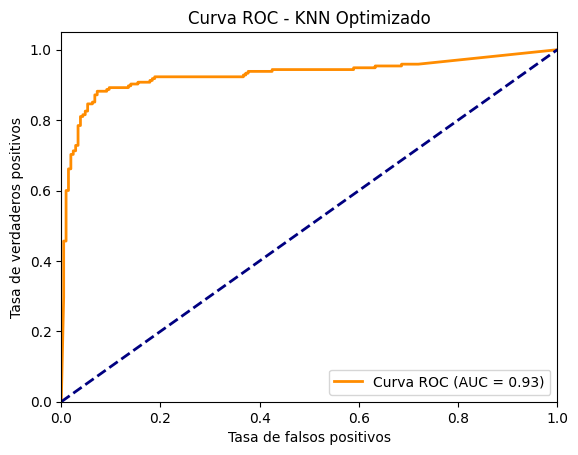

In [10]:
# Evaluación de los modelos optimizados
y_pred_opt_knn = grid_search_knn.best_estimator_.predict(X_test)
y_pred_opt_tree = random_search_tree.best_estimator_.predict(X_test)

# Imprimir los resultados de los modelos optimizados
print("KNN Optimizado - Evaluación:")
print(classification_report(y_test, y_pred_opt_knn))
print(confusion_matrix(y_test, y_pred_opt_knn))

print("Árbol de Decisión Optimizado - Evaluación:")
print(classification_report(y_test, y_pred_opt_tree))
print(confusion_matrix(y_test, y_pred_opt_tree))

# Curva ROC para el modelo optimizado KNN
fpr, tpr, thresholds = roc_curve(y_test, grid_search_knn.best_estimator_.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - KNN Optimizado')
plt.legend(loc="lower right")
plt.show()


Evaluación de Regresión Logística
Métricas:
Precision:

Clase 0 (no alto costo): 0.91
Clase 1 (alto costo): 0.89
La precisión es bastante alta para ambas clases, pero ligeramente mejor para la clase 0.
Recall (Sensibilidad):

Clase 0 (no alto costo): 0.90
Clase 1 (alto costo): 0.90
El recall es equilibrado para ambas clases, con un pequeño margen de diferencia (0.90 frente a 0.89).
F1-Score:

Clase 0: 0.90
Clase 1: 0.90
El F1-score es muy equilibrado para ambas clases, lo que es una indicación de que el modelo tiene un buen equilibrio entre precisión y recall.
Accuracy (Exactitud): 0.90

El modelo tiene una exactitud del 90%, lo cual es excelente y está en la misma línea que el rendimiento de los otros dos modelos (KNN y Árbol de Decisión).
Falsos Positivos (FP): 21 (predicciones incorrectas de la clase 1 cuando realmente son de clase 0).
Falsos Negativos (FN): 19 (predicciones incorrectas de la clase 0 cuando realmente son de clase 1).

Evaluación de KNN Optimizado
Métricas:
Precision: Mide la exactitud de las predicciones positivas.

Clase 0 (no alto costo): 0.89
Clase 1 (alto costo): 0.92
En general, el modelo tiene una buena precisión en ambas clases.
Recall (Sensibilidad): Mide la capacidad del modelo para identificar todos los casos positivos.

Clase 0 (no alto costo): 0.93
Clase 1 (alto costo): 0.87
El modelo tiene un alto recall para la clase 0, pero un recall algo menor para la clase 1 (lo que podría significar que está perdiendo algunos casos positivos de la clase 1).
F1-Score: Es la media armónica entre precisión y recall, y es un buen indicador de rendimiento general cuando las clases están desbalanceadas.

Clase 0: 0.91
Clase 1: 0.90
El F1-score es alto y muy equilibrado entre las dos clases, lo que indica un buen compromiso entre precisión y recall.
Accuracy (Exactitud): 0.90

El modelo tiene una exactitud del 90%, lo que es bastante bueno.

Matriz de Confusión: Falsos Positivos (FP): 14 (predicciones incorrectas de la clase 1 cuando realmente son de clase 0).
Falsos Negativos (FN): 25 (predicciones incorrectas de la clase 0 cuando realmente son de clase 1).

Evaluación de Árbol de Decisión Optimizado
Métricas:
Precision:

Clase 0 (no alto costo): 0.87
Clase 1 (alto costo): 0.98
El modelo tiene buena precisión para la clase 1, pero su precisión para la clase 0 es un poco más baja en comparación con KNN.
Recall (Sensibilidad):

Clase 0 (no alto costo): 0.99
Clase 1 (alto costo): 0.85
El modelo tiene un recall excepcional para la clase 0 (casi perfecto), pero pierde algo de capacidad para detectar correctamente los casos de la clase 1 (recall más bajo que KNN).
F1-Score:

Clase 0: 0.93
Clase 1: 0.91
El F1-score también es alto, con un buen equilibrio entre precisión y recall, aunque ligeramente mejor para la clase 0.
Accuracy (Exactitud): 0.92

El modelo de Árbol de Decisión tiene una exactitud del 92%, lo que es un poco mejor que el KNN.

Matriz de Confusión:Falsos Positivos (FP): 3 (muy pocos falsos positivos, muy buena identificación de la clase 0).
Falsos Negativos (FN): 30 (aunque el recall para la clase 1 es más bajo, el modelo aún tiene un buen desempeño, pero está perdiendo algunos casos positivos de la clase 1).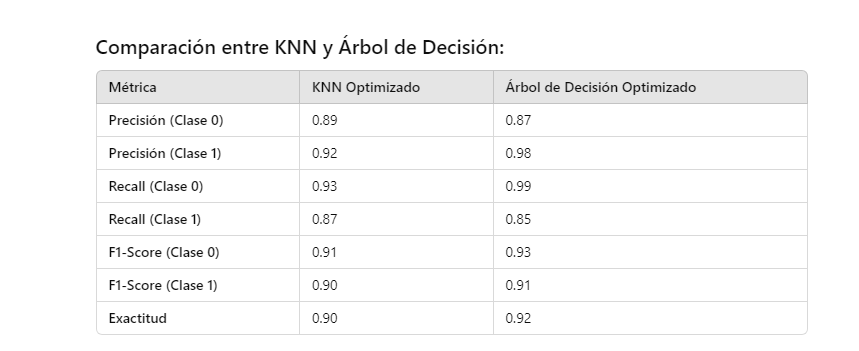

***Análisis de la Curva ROC ***
En la gráfica se observa lo siguiente:

AUC de 0.93: Este valor es bastante alto, lo que indica que el modelo KNN optimizado tiene un excelente rendimiento en la clasificación.
Forma de la curva: La curva se encuentra muy cerca de la esquina superior izquierda, lo que confirma la alta capacidad discriminativa del modelo.
**Conclusiones**
El modelo KNN optimizado es altamente preciso: Con un AUC de 0.93, el modelo demuestra una gran capacidad para distinguir entre las dos clases.
La optimización del modelo ha sido exitosa: El proceso de optimización ha llevado a un modelo con un rendimiento superior.
El modelo es una buena opción para la tarea de clasificación: Dada su alta precisión, este modelo puede ser utilizado de manera confiable en aplicaciones reales.

**Análisis:**
Exactitud: Los tres modelos (Regresión Logística, KNN y Árbol de Decisión) tienen un rendimiento similar en términos de exactitud. El Árbol de Decisión tiene un pequeño plus en la exactitud (0.92 frente a 0.90 de los otros dos).

Precisión:

Para la clase 0 (no alto costo), la Regresión Logística tiene la mejor precisión (0.91), seguida de KNN (0.89) y Árbol de Decisión (0.87).
Para la clase 1 (alto costo), el Árbol de Decisión tiene la mejor precisión (0.98), mientras que KNN sigue a la par (0.92) y Regresión Logística tiene 0.89.
Recall:

Para la clase 0, el Árbol de Decisión sobresale con un recall casi perfecto (0.99), mientras que KNN tiene un recall de 0.93 y Regresión Logística tiene 0.90.
Para la clase 1, la Regresión Logística y Árbol de Decisión tienen un recall similar (0.90 y 0.85, respectivamente), con KNN siendo el modelo con el menor recall para esta clase (0.87).
F1-Score: Todos los modelos muestran un buen F1-score. El Árbol de Decisión tiene una ligera ventaja para la clase 0 (0.93 frente a 0.90 en Regresión Logística), pero los F1-scores para la clase 1 están bastante equilibrados en todos los modelos (0.90).

**Conclusión:**
Árbol de Decisión sigue destacándose en términos de exactitud y recall para la clase 0, aunque tiene un pequeño sacrificio en recall para la clase 1.
Regresión Logística es un modelo bien equilibrado con precisiones similares en ambas clases (0.91 para clase 0 y 0.89 para clase 1), junto con un recall equilibrado (0.90 para ambas clases).
KNN muestra un buen rendimiento en recall para la clase 0 (0.93), pero se queda atrás en recall para la clase 1 y precisión en la clase 1 (0.87 de recall).